Visualizations - Target Values

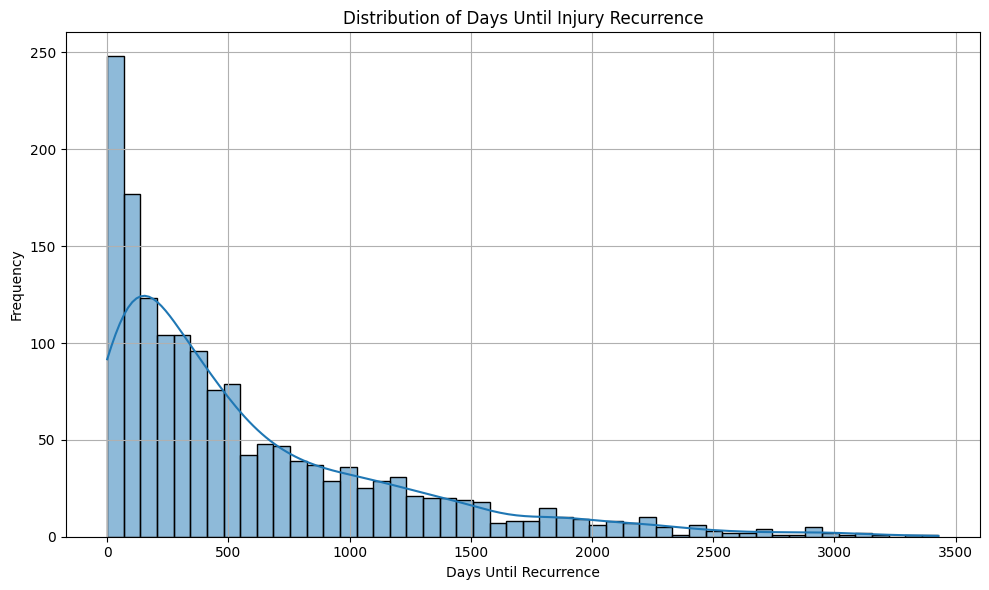

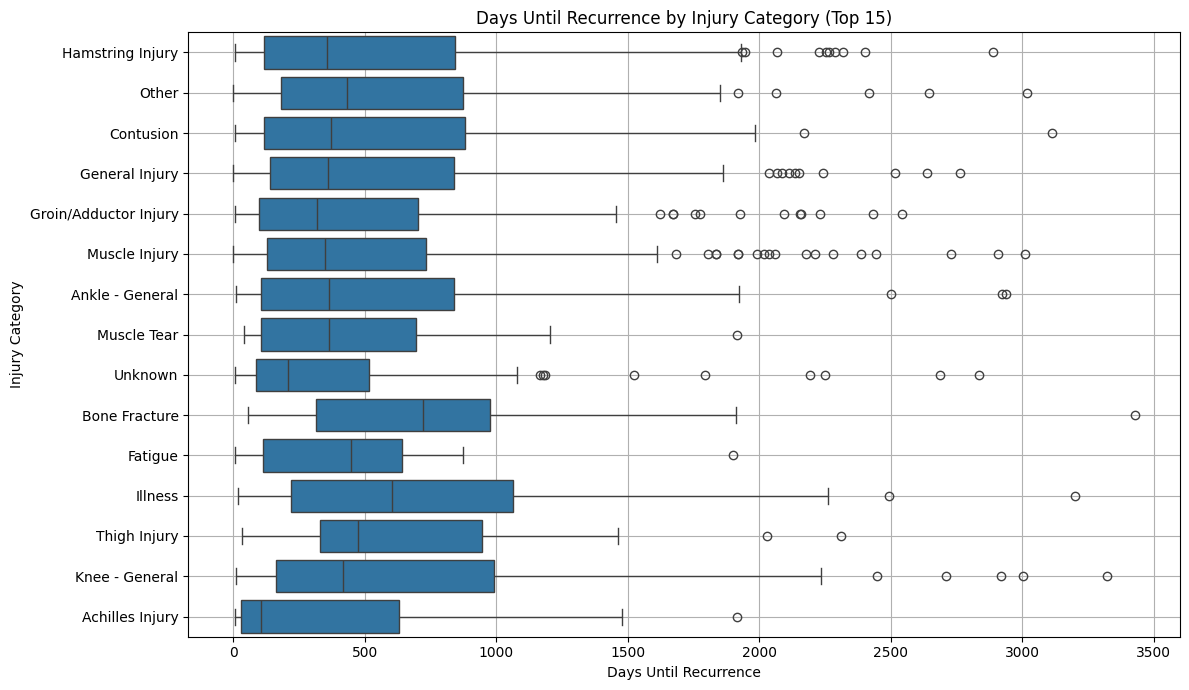

/tmp/ipython-input-3248523193.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='recurrence_rate', y=recur_counts.index, data=recur_counts, palette='viridis')


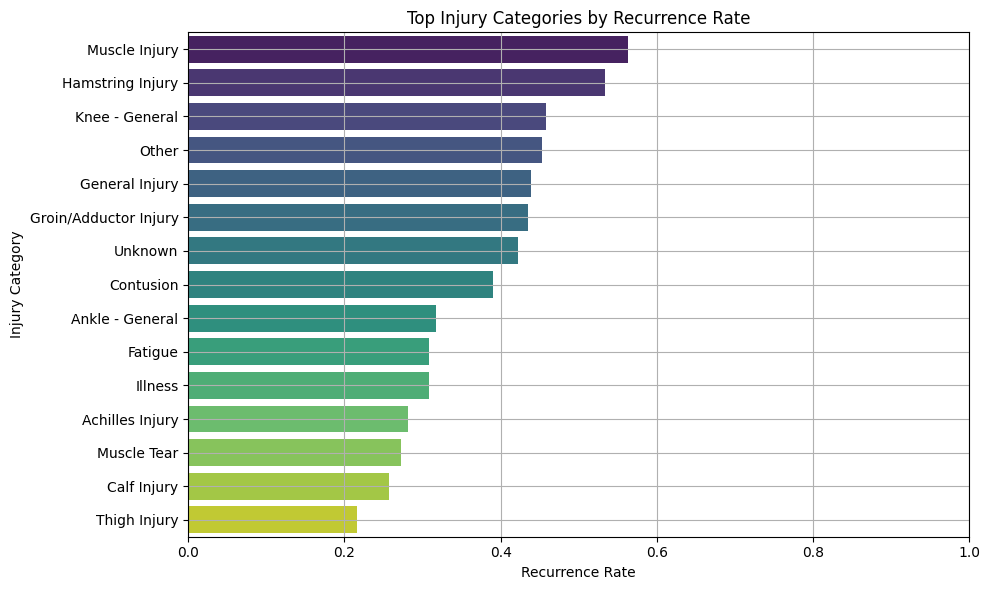

/tmp/ipython-input-3248523193.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_avg = recur_age.groupby('age_group')['days_until_recurrence'].mean().reset_index()
/tmp/ipython-input-3248523193.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_group_avg, x='age_group', y='days_until_recurrence', palette='mako')


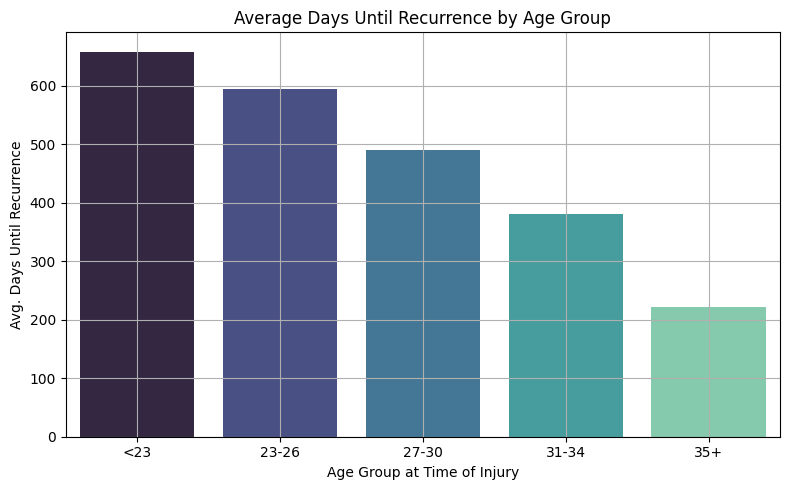

/tmp/ipython-input-3248523193.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_recur_by_category.values, y=mean_recur_by_category.index, palette="crest")


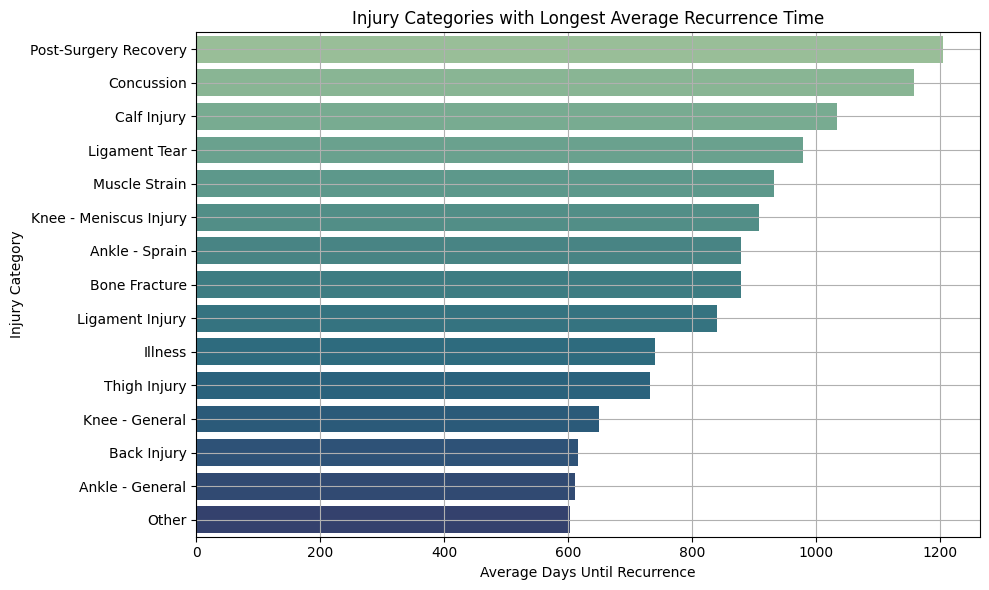

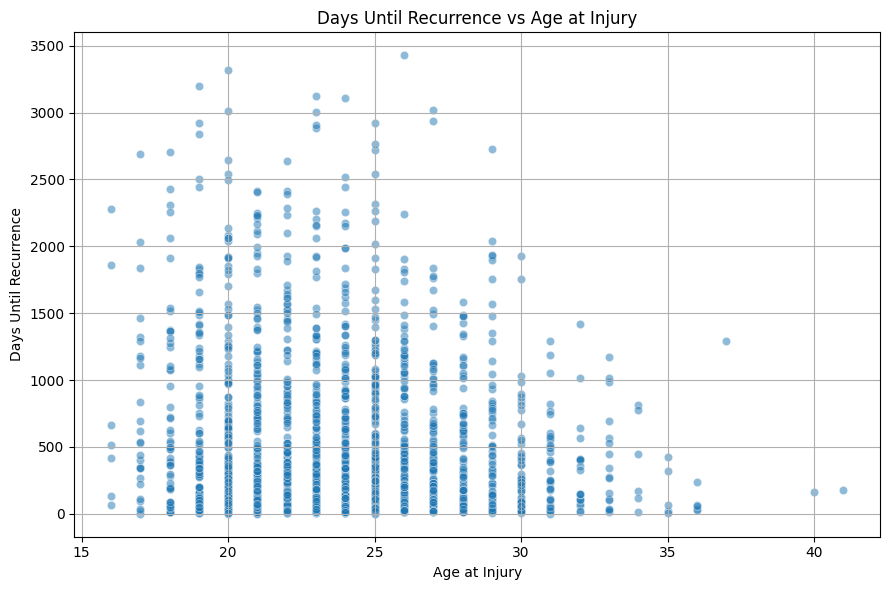

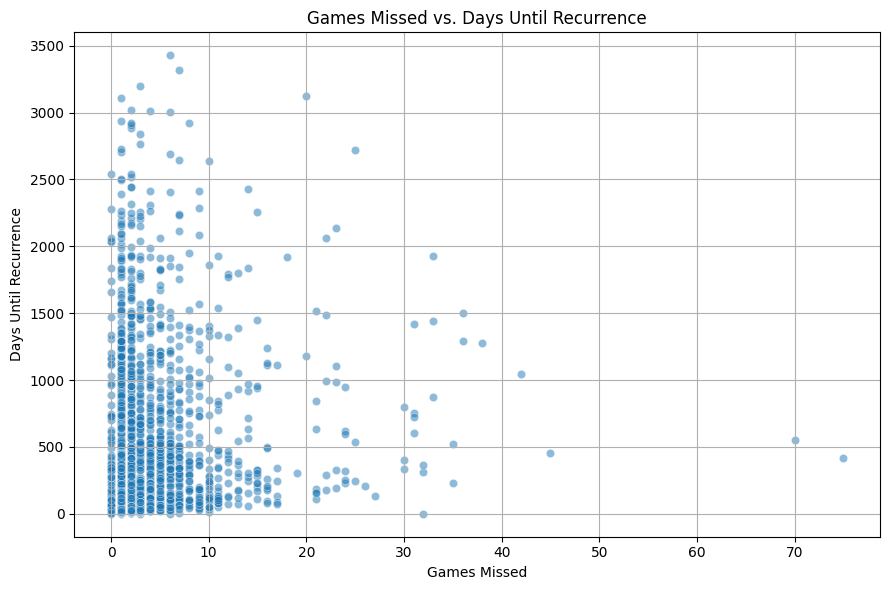

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = pd.read_csv("DataFinal.csv")

# Distribution of Days Until Recurrence
plt.figure(figsize=(10, 6))
sns.histplot(df['days_until_recurrence'].dropna(), bins=50, kde=True)
plt.title("Distribution of Days Until Injury Recurrence")
plt.xlabel("Days Until Recurrence")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

#  Boxplot of Recurrence Time by Injury Category
top_categories = (
    df[df['days_until_recurrence'].notnull()]
    .groupby('category')
    .size()
    .sort_values(ascending=False)
    .head(15)
)
top_df = df[df['category'].isin(top_categories.index)]

plt.figure(figsize=(12, 7))
sns.boxplot(data=top_df, x='days_until_recurrence', y='category')
plt.title("Days Until Recurrence by Injury Category (Top 15)")
plt.xlabel("Days Until Recurrence")
plt.ylabel("Injury Category")
plt.grid(True)
plt.tight_layout()
plt.show()

#  Recurrence Rate by Injury Category
recur_counts = (
    df.groupby('category')['player_name'].count().rename("total_cases").to_frame()
    .join(
        df[df['days_until_recurrence'].notnull()]
        .groupby('category')['player_name']
        .count()
        .rename("recurrence_cases")
    )
)
recur_counts['recurrence_rate'] = recur_counts['recurrence_cases'] / recur_counts['total_cases']
recur_counts = recur_counts.dropna().sort_values(by='recurrence_rate', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='recurrence_rate', y=recur_counts.index, data=recur_counts, palette='viridis')
plt.title("Top Injury Categories by Recurrence Rate")
plt.xlabel("Recurrence Rate")
plt.ylabel("Injury Category")
plt.xlim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# Average Days Until Recurrence by Age Group
age_bins = [0, 22, 26, 30, 34, 100]
age_labels = ['<23', '23-26', '27-30', '31-34', '35+']
df['age_group'] = pd.cut(df['age_at_injury'], bins=age_bins, labels=age_labels)

recur_age = df[df['days_until_recurrence'].notnull()]
age_group_avg = recur_age.groupby('age_group')['days_until_recurrence'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=age_group_avg, x='age_group', y='days_until_recurrence', palette='mako')
plt.title("Average Days Until Recurrence by Age Group")
plt.xlabel("Age Group at Time of Injury")
plt.ylabel("Avg. Days Until Recurrence")
plt.grid(True)
plt.tight_layout()
plt.show()

# Longest Average Recurrence Time by Category
mean_recur_by_category = (
    df[df['days_until_recurrence'].notnull()]
    .groupby('category')['days_until_recurrence']
    .mean()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=mean_recur_by_category.values, y=mean_recur_by_category.index, palette="crest")
plt.title("Injury Categories with Longest Average Recurrence Time")
plt.xlabel("Average Days Until Recurrence")
plt.ylabel("Injury Category")
plt.grid(True)
plt.tight_layout()
plt.show()

# Age at Injury vs Days Until Recurrence
plt.figure(figsize=(9, 6))
sns.scatterplot(data=df[df['days_until_recurrence'].notnull()],
                x='age_at_injury',
                y='days_until_recurrence',
                alpha=0.5)
plt.title("Days Until Recurrence vs Age at Injury")
plt.xlabel("Age at Injury")
plt.ylabel("Days Until Recurrence")
plt.grid(True)
plt.tight_layout()
plt.show()

# Games Missed vs. Days Until Recurrence
plt.figure(figsize=(9, 6))
sns.scatterplot(data=df[df['days_until_recurrence'].notnull()],
                x='games_missed',
                y='days_until_recurrence',
                alpha=0.5)
plt.title("Games Missed vs. Days Until Recurrence")
plt.xlabel("Games Missed")
plt.ylabel("Days Until Recurrence")
plt.grid(True)
plt.tight_layout()
plt.show()


Regression target - Days Until Recurrence //  Models process and results

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor


# Check
df = df[df['days_until_recurrence'].notnull()]

features = ['age_at_injury', 'games_missed', 'duration', 'position', 'category']
target = 'days_until_recurrence'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

categorical_features = ['position', 'category']
numerical_features = ['age_at_injury', 'games_missed', 'duration']

default_preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

scaled_preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
], remainder='drop')

# Testing the models.
# Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('regressor', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_mae = mean_absolute_error(y_test, lr_preds)
print(f"Linear Regression: RMSE: {lr_rmse:.2f}, MAE: {lr_mae:.2f}")

# Ridge Regression
ridge_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('regressor', Ridge())
])
ridge_pipeline.fit(X_train, y_train)
ridge_preds = ridge_pipeline.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
ridge_mae = mean_absolute_error(y_test, ridge_preds)
print(f"Ridge Regression: RMSE: {ridge_rmse:.2f}, MAE: {ridge_mae:.2f}")

# Lasso Regression
lasso_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('regressor', Lasso())
])
lasso_pipeline.fit(X_train, y_train)
lasso_preds = lasso_pipeline.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))
lasso_mae = mean_absolute_error(y_test, lasso_preds)
print(f"Lasso Regression: RMSE: {lasso_rmse:.2f}, MAE: {lasso_mae:.2f}")

# Decision Tree
tree_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])
tree_pipeline.fit(X_train, y_train)
tree_preds = tree_pipeline.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, tree_preds))
tree_mae = mean_absolute_error(y_test, tree_preds)
print(f"Decision Tree: RMSE: {tree_rmse:.2f}, MAE: {tree_mae:.2f}")

# Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mae = mean_absolute_error(y_test, rf_preds)
print(f"Random Forest: RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}")

# Gradient Boosting
gb_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])
gb_pipeline.fit(X_train, y_train)
gb_preds = gb_pipeline.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_preds))
gb_mae = mean_absolute_error(y_test, gb_preds)
print(f"Gradient Boosting: RMSE: {gb_rmse:.2f}, MAE: {gb_mae:.2f}")

# XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
])
xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_mae = mean_absolute_error(y_test, xgb_preds)
print(f"XGBoost: RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}")

# KNN
knn_pipeline = Pipeline([
    ('preprocessor', scaled_preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=5))
])
knn_pipeline.fit(X_train, y_train)
knn_preds = knn_pipeline.predict(X_test)
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_preds))
knn_mae = mean_absolute_error(y_test, knn_preds)
print(f"KNN: RMSE: {knn_rmse:.2f}, MAE: {knn_mae:.2f}")

Linear Regression: RMSE: 602.13, MAE: 469.61
Ridge Regression: RMSE: 601.58, MAE: 469.61
Lasso Regression: RMSE: 600.19, MAE: 468.97
Decision Tree: RMSE: 825.75, MAE: 585.17
Random Forest: RMSE: 630.18, MAE: 478.23
Gradient Boosting: RMSE: 624.34, MAE: 480.26
XGBoost: RMSE: 688.80, MAE: 513.61
KNN: RMSE: 637.78, MAE: 486.43


Visualizations

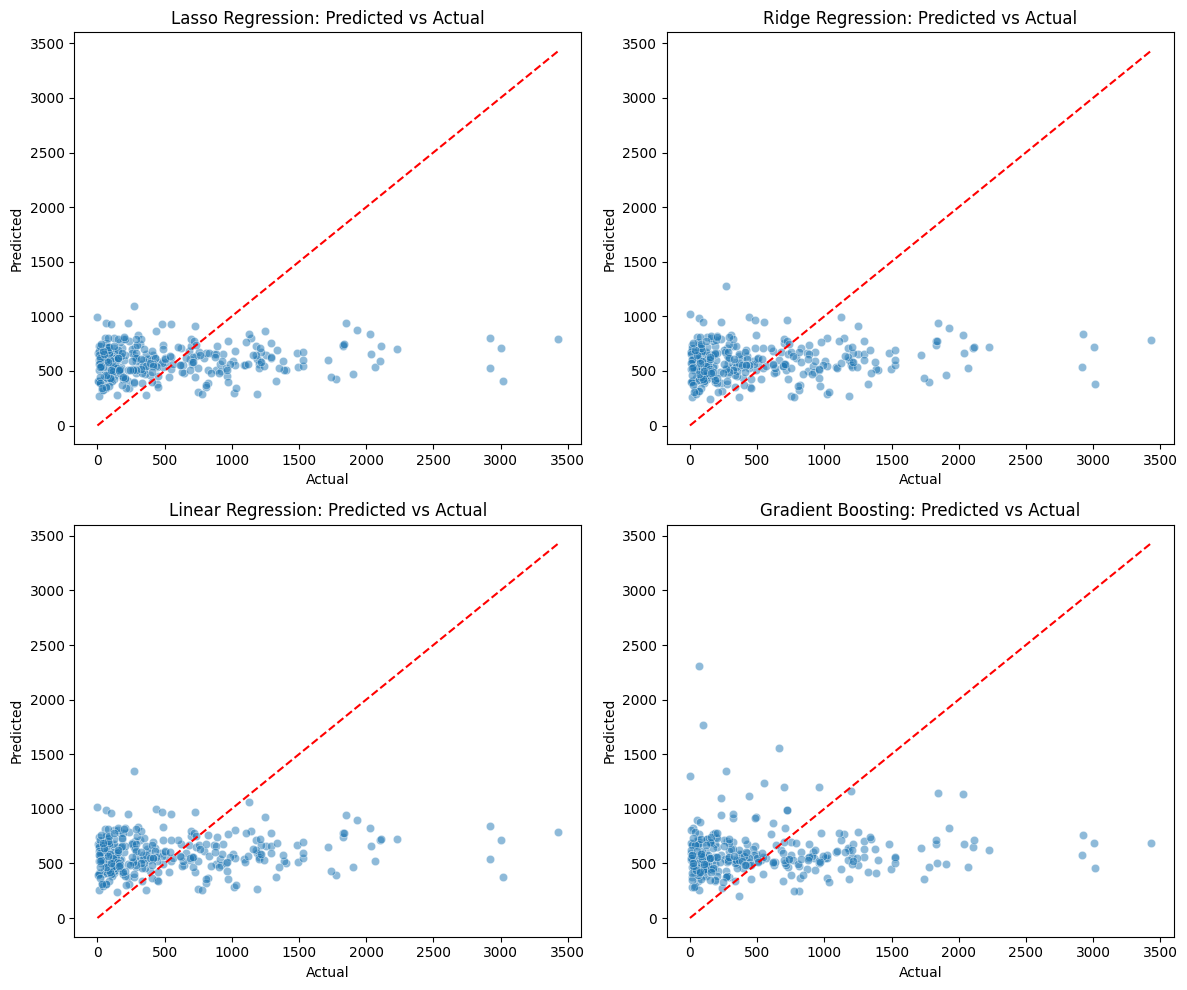

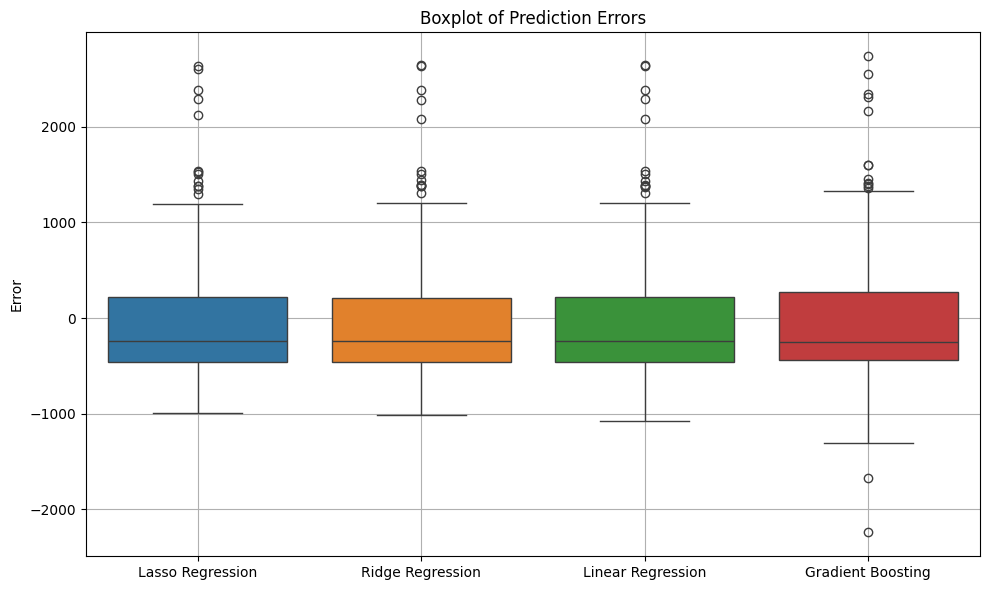

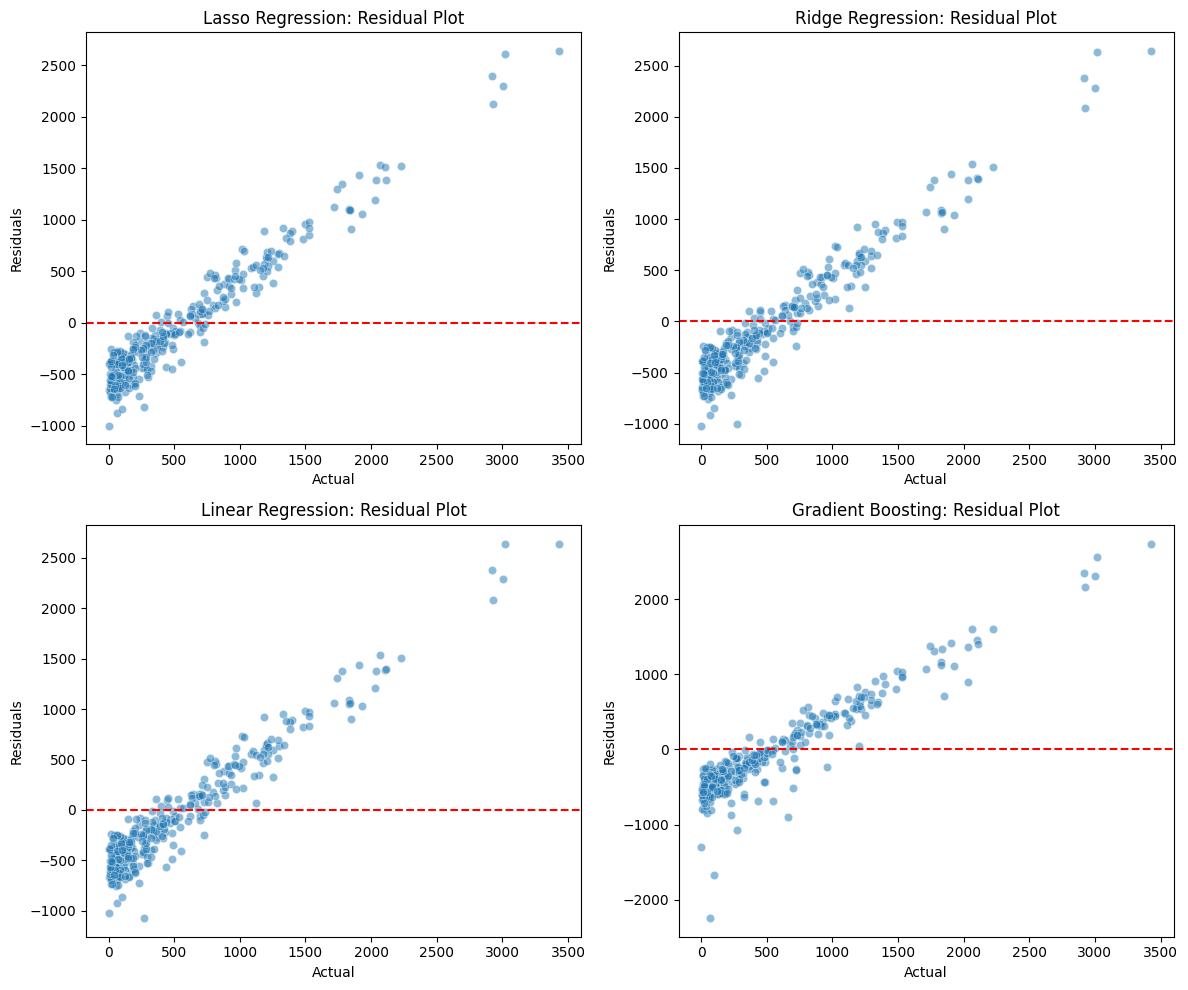

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# Get Predictions
def get_predictions(preprocessor, model):
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    return pipe.predict(X_test)

# Selected Models
y_pred_lasso = get_predictions(default_preprocessor, Lasso())
y_pred_ridge = get_predictions(default_preprocessor, Ridge())
y_pred_linear = get_predictions(default_preprocessor, LinearRegression())
y_pred_gb = get_predictions(default_preprocessor, GradientBoostingRegressor(random_state=42))

preds = {
    "Lasso Regression": y_pred_lasso,
    "Ridge Regression": y_pred_ridge,
    "Linear Regression": y_pred_linear,
    "Gradient Boosting": y_pred_gb
}

# Predicted vs Actual Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (model, y_pred) in enumerate(preds.items()):
    sns.scatterplot(x=y_test, y=y_pred, ax=axes[i], alpha=0.5)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[i].set_title(f"{model}: Predicted vs Actual")
    axes[i].set_xlabel("Actual")
    axes[i].set_ylabel("Predicted")

plt.tight_layout()
plt.show()

# Boxplot of Prediction Errors
errors_df = pd.DataFrame({
    model: y_test - pred for model, pred in preds.items()
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=errors_df)
plt.title("Boxplot of Prediction Errors")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (model, y_pred) in enumerate(preds.items()):
    residuals = y_test - y_pred
    sns.scatterplot(x=y_test, y=residuals, ax=axes[i], alpha=0.5)
    axes[i].axhline(0, color='r', linestyle='--')
    axes[i].set_title(f"{model}: Residual Plot")
    axes[i].set_xlabel("Actual")
    axes[i].set_ylabel("Residuals")

plt.tight_layout()
plt.show()


Classification target - Recurrence Injury

Models process and results

In [4]:
# Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # Fast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

df = pd.read_csv("DataFinal.csv")
# Feature and target selection
features = ['age_at_injury', 'games_missed', 'duration', 'position', 'category']
target = 'recur_same_injury'

X = df[features]
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
categorical_features = ['position', 'category']
numerical_features = ['age_at_injury', 'games_missed', 'duration']

default_preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

scaled_preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
], remainder='drop')


# Logistic Regression
logreg_pipeline = Pipeline([
    ('preprocessor', scaled_preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
logreg_pipeline.fit(X_train, y_train)
logreg_preds = logreg_pipeline.predict(X_test)
print("Logistic Regression:")
print("Accuracy:", round(accuracy_score(y_test, logreg_preds), 3))
print("Precision:", round(precision_score(y_test, logreg_preds), 3))
print("Recall:", round(recall_score(y_test, logreg_preds), 3))
print("F1-Score:", round(f1_score(y_test, logreg_preds), 3))
print()

# Decision Tree
tree_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
tree_pipeline.fit(X_train, y_train)
tree_preds = tree_pipeline.predict(X_test)
print("Decision Tree:")
print("Accuracy:", round(accuracy_score(y_test, tree_preds), 3))
print("Precision:", round(precision_score(y_test, tree_preds), 3))
print("Recall:", round(recall_score(y_test, tree_preds), 3))
print("F1-Score:", round(f1_score(y_test, tree_preds), 3))
print()

# Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)
print("Random Forest:")
print("Accuracy:", round(accuracy_score(y_test, rf_preds), 3))
print("Precision:", round(precision_score(y_test, rf_preds), 3))
print("Recall:", round(recall_score(y_test, rf_preds), 3))
print("F1-Score:", round(f1_score(y_test, rf_preds), 3))
print()

# Gradient Boosting
gb_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
gb_pipeline.fit(X_train, y_train)
gb_preds = gb_pipeline.predict(X_test)
print("Gradient Boosting:")
print("Accuracy:", round(accuracy_score(y_test, gb_preds), 3))
print("Precision:", round(precision_score(y_test, gb_preds), 3))
print("Recall:", round(recall_score(y_test, gb_preds), 3))
print("F1-Score:", round(f1_score(y_test, gb_preds), 3))
print()

# AdaBoost
ada_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('classifier', AdaBoostClassifier())
])
ada_pipeline.fit(X_train, y_train)
ada_preds = ada_pipeline.predict(X_test)
print("AdaBoost:")
print("Accuracy:", round(accuracy_score(y_test, ada_preds), 3))
print("Precision:", round(precision_score(y_test, ada_preds), 3))
print("Recall:", round(recall_score(y_test, ada_preds), 3))
print("F1-Score:", round(f1_score(y_test, ada_preds), 3))
print()

# XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)
print("XGBoost:")
print("Accuracy:", round(accuracy_score(y_test, xgb_preds), 3))
print("Precision:", round(precision_score(y_test, xgb_preds), 3))
print("Recall:", round(recall_score(y_test, xgb_preds), 3))
print("F1-Score:", round(f1_score(y_test, xgb_preds), 3))
print()

# LightGBM
lgbm_pipeline = Pipeline([
    ('preprocessor', default_preprocessor),
    ('classifier', LGBMClassifier())
])
lgbm_pipeline.fit(X_train, y_train)
lgbm_preds = lgbm_pipeline.predict(X_test)
print("LightGBM:")
print("Accuracy:", round(accuracy_score(y_test, lgbm_preds), 3))
print("Precision:", round(precision_score(y_test, lgbm_preds), 3))
print("Recall:", round(recall_score(y_test, lgbm_preds), 3))
print("F1-Score:", round(f1_score(y_test, lgbm_preds), 3))
print()

# KNN
knn_pipeline = Pipeline([
    ('preprocessor', scaled_preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])
knn_pipeline.fit(X_train, y_train)
knn_preds = knn_pipeline.predict(X_test)
print("KNN:")
print("Accuracy:", round(accuracy_score(y_test, knn_preds), 3))
print("Precision:", round(precision_score(y_test, knn_preds), 3))
print("Recall:", round(recall_score(y_test, knn_preds), 3))
print("F1-Score:", round(f1_score(y_test, knn_preds), 3))
print()

Logistic Regression:
Accuracy: 0.667
Precision: 0.671
Recall: 0.89
F1-Score: 0.765

Decision Tree:
Accuracy: 0.595
Precision: 0.663
Recall: 0.683
F1-Score: 0.673

Random Forest:
Accuracy: 0.644
Precision: 0.675
Recall: 0.803
F1-Score: 0.734

Gradient Boosting:
Accuracy: 0.677
Precision: 0.666
Recall: 0.944
F1-Score: 0.781

AdaBoost:
Accuracy: 0.635
Precision: 0.628
Recall: 0.988
F1-Score: 0.768



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:08:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost:
Accuracy: 0.654
Precision: 0.678
Recall: 0.826
F1-Score: 0.745

[LightGBM] [Info] Number of positive: 1988, number of negative: 1168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 281
[LightGBM] [Info] Number of data points in the train set: 3156, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.629911 -> initscore=0.531836
[LightGBM] [Info] Start training from score 0.531836
LightGBM:
Accuracy: 0.648
Precision: 0.671
Recall: 0.832
F1-Score: 0.743



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


KNN:
Accuracy: 0.611
Precision: 0.645
Recall: 0.807
F1-Score: 0.717



Visualization

[LightGBM] [Info] Number of positive: 1988, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 281
[LightGBM] [Info] Number of data points in the train set: 3156, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.629911 -> initscore=0.531836
[LightGBM] [Info] Start training from score 0.531836


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


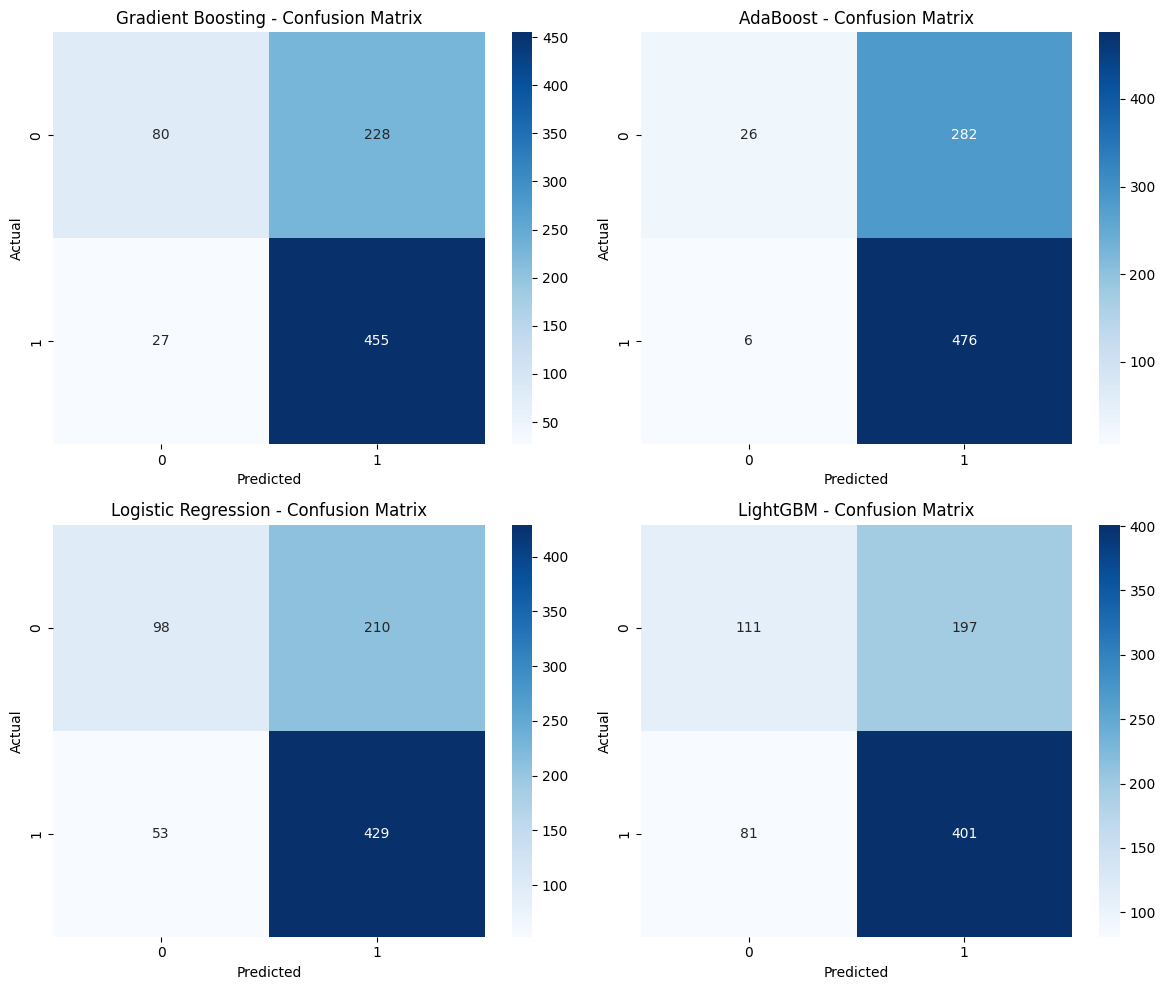

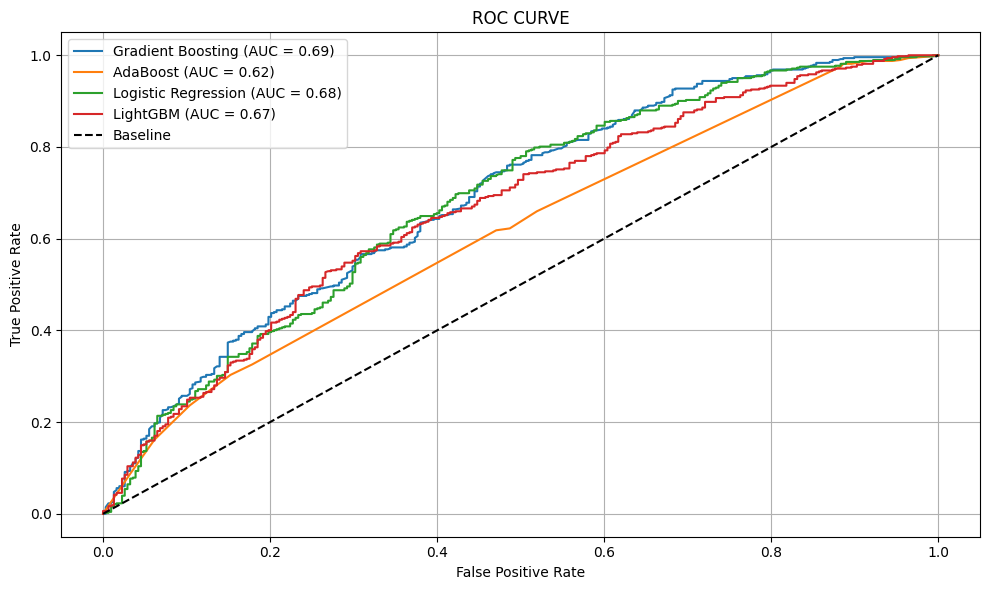

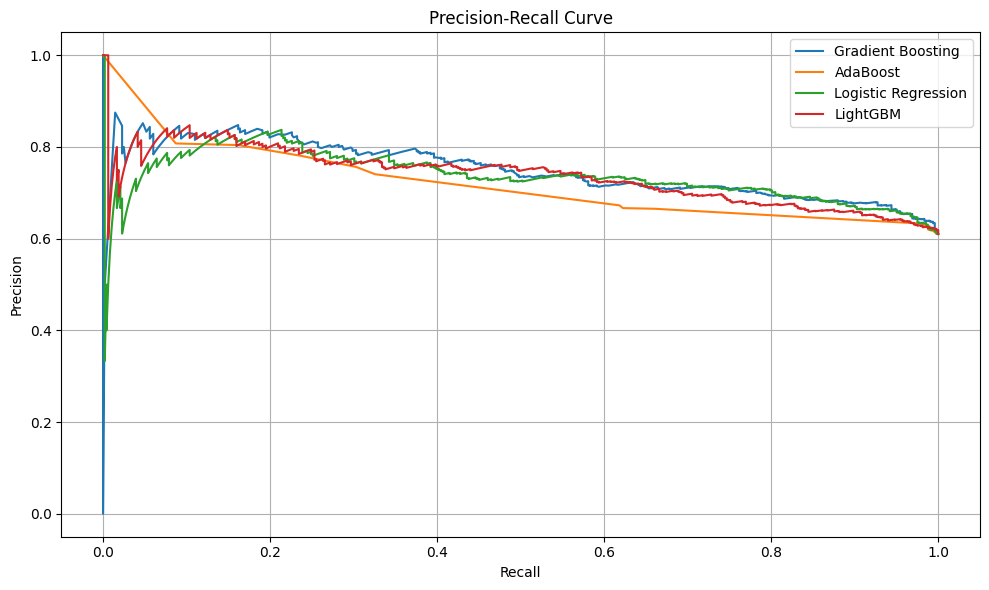

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
import numpy as np

# Model
top_models = {
    "Gradient Boosting": (default_preprocessor, GradientBoostingClassifier(random_state=42)),
    "AdaBoost": (default_preprocessor, AdaBoostClassifier()),
    "Logistic Regression": (scaled_preprocessor, LogisticRegression(max_iter=1000)),
    "LightGBM": (default_preprocessor, LGBMClassifier())
}

y_scores = {}
y_preds = {}

# Fit and collect predictions
for name, (prep, model) in top_models.items():
    pipe = Pipeline([('preprocessor', prep), ('classifier', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    y_preds[name] = y_pred
    y_scores[name] = y_prob

# Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for i, (name, y_pred) in enumerate(y_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{name} - Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC
plt.figure(figsize=(10, 6))
for name, y_prob in y_scores.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Baseline")
plt.title("ROC CURVE")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision
plt.figure(figsize=(10, 6))
for name, y_prob in y_scores.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=name)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
